# Data Splitting

In [1]:
# import os
# import shutil
# import random
# from sklearn.model_selection import train_test_split

# # Define paths
# train_dir = 'dataset/train'
# val_dir = 'dataset/val'

# # Calculate the number of classes based on directories in the train folder
# classes = [d.name for d in os.scandir(train_dir) if d.is_dir()]
# num_classes = len(classes)
# print(f"Number of classes: {num_classes}")

In [2]:
# def split_data(train_dir, val_dir, split_size=0.2):
#     for cls in classes:
#         cls_dir = os.path.join(train_dir, cls)
#         images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith('.JPG')]

#         # Check if there are images in the class directory
#         if len(images) == 0:
#             print(f"No images found in class {cls}. Skipping this class.")
#             continue

#         # Split the data
#         train_imgs, val_imgs = train_test_split(images, test_size=split_size)

#         # Create corresponding directory in val_dir
#         val_cls_dir = os.path.join(val_dir, cls)
#         os.makedirs(val_cls_dir, exist_ok=True)

#         # Move/copy validation images
#         for img in val_imgs:
#             shutil.move(img, val_cls_dir)  # Use shutil.copy if you want to keep the original

# # Call the function to split the data
# split_data(train_dir, val_dir)

# Train

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='dataset/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/val', transform=transform)

print(train_dataset.class_to_idx)
print(val_dataset.class_to_idx)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

{'10526_Armillaria_mellea': 0, '10527_Armillaria_ostoyae': 1, '10934_Auricularia_auricula-judae': 2, '10937_Auricularia_mesenterica': 3, '11069_Boletus_edulis': 4, '11083_Boletus_pinophilus': 5, '11093_Boletus_reticulatus': 6, '11314_Cantharellus_amethysteus': 7, '11317_Cantharellus_cibarius': 8, '11325_Cantharellus_pallens': 9, '11746_Clitocybe_agrestis': 10, '11748_Clitocybe_alexandri': 11, '11760_Clitocybe_diatreta': 12, '11762_Clitocybe_ditopus': 13, '11767_Clitocybe_fragrans': 14, '11787_Clitocybe_metachroa': 15, '11796_Clitocybe_phaeophthalma': 16, '11797_Clitocybe_phyllophila': 17, '11803_Clitocybe_rivulosa': 18, '11813_Clitocybe_trulliformis': 19, '11816_Clitocybe_vibecina': 20, '12763_Hericium_cirrhatum': 21, '14056_Flammulina_velutipes var. velutipes': 22, '14155_Ganoderma_adspersum': 23, '14158_Ganoderma_applanatum': 24, '14159_Ganoderma_lucidum': 25, '14160_Ganoderma_pfeifferi': 26, '14161_Ganoderma_resinaceum': 27, '14394_Grifola_frondosa': 28, '14667_Hericium_coralloides'

In [4]:
import torch
from torch import nn
import torch.nn.functional as F

# Load Pre-trained DeiT Model
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Adjust the classifier for your number of classes
num_classes = len(train_dataset.classes)
model.head = nn.Linear(model.head.in_features, num_classes)
# model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main
/home/samxu/documents/apply_ai/final_fungus-detector/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers
for param in model.head.parameters():
    param.requires_grad = True

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [7]:
import copy
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs} [{phase}]"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)

Epoch 1/100
----------


Epoch 1/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.39it/s]


train Loss: 1.2490 Acc: 0.7001


Epoch 1/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.8539 Acc: 0.5091

Epoch 2/100
----------


Epoch 2/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 1.0643 Acc: 0.7477


Epoch 2/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 1.7818 Acc: 0.5298

Epoch 3/100
----------


Epoch 3/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.45it/s]


train Loss: 0.9207 Acc: 0.7900


Epoch 3/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.89it/s]


val Loss: 1.7496 Acc: 0.5303

Epoch 4/100
----------


Epoch 4/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.8068 Acc: 0.8248


Epoch 4/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.92it/s]


val Loss: 1.7202 Acc: 0.5459

Epoch 5/100
----------


Epoch 5/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.7121 Acc: 0.8492


Epoch 5/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 1.6917 Acc: 0.5605

Epoch 6/100
----------


Epoch 6/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.6372 Acc: 0.8705


Epoch 6/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 1.6834 Acc: 0.5545

Epoch 7/100
----------


Epoch 7/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.5740 Acc: 0.8939


Epoch 7/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 1.6788 Acc: 0.5494

Epoch 8/100
----------


Epoch 8/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.5190 Acc: 0.9034


Epoch 8/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


val Loss: 1.6773 Acc: 0.5616

Epoch 9/100
----------


Epoch 9/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.4719 Acc: 0.9173


Epoch 9/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 1.6818 Acc: 0.5666

Epoch 10/100
----------


Epoch 10/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.4278 Acc: 0.9289


Epoch 10/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.6763 Acc: 0.5631

Epoch 11/100
----------


Epoch 11/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.62it/s]


train Loss: 0.3903 Acc: 0.9393


Epoch 11/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.6902 Acc: 0.5747

Epoch 12/100
----------


Epoch 12/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.3578 Acc: 0.9470


Epoch 12/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 1.7023 Acc: 0.5621

Epoch 13/100
----------


Epoch 13/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.52it/s]


train Loss: 0.3279 Acc: 0.9522


Epoch 13/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.7034 Acc: 0.5727

Epoch 14/100
----------


Epoch 14/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.3012 Acc: 0.9613


Epoch 14/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.7129 Acc: 0.5651

Epoch 15/100
----------


Epoch 15/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.2773 Acc: 0.9661


Epoch 15/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.7278 Acc: 0.5686

Epoch 16/100
----------


Epoch 16/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.2560 Acc: 0.9714


Epoch 16/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 1.7538 Acc: 0.5651

Epoch 17/100
----------


Epoch 17/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.2382 Acc: 0.9724


Epoch 17/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.7479 Acc: 0.5671

Epoch 18/100
----------


Epoch 18/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.2191 Acc: 0.9770


Epoch 18/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 1.7632 Acc: 0.5646

Epoch 19/100
----------


Epoch 19/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.2024 Acc: 0.9801


Epoch 19/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 1.7807 Acc: 0.5671

Epoch 20/100
----------


Epoch 20/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.1882 Acc: 0.9831


Epoch 20/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 1.7991 Acc: 0.5691

Epoch 21/100
----------


Epoch 21/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.1755 Acc: 0.9852


Epoch 21/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 1.7969 Acc: 0.5727

Epoch 22/100
----------


Epoch 22/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.1621 Acc: 0.9870


Epoch 22/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 1.8216 Acc: 0.5721

Epoch 23/100
----------


Epoch 23/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.1499 Acc: 0.9891


Epoch 23/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 1.8324 Acc: 0.5721

Epoch 24/100
----------


Epoch 24/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.50it/s]


train Loss: 0.1398 Acc: 0.9889


Epoch 24/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 1.8531 Acc: 0.5600

Epoch 25/100
----------


Epoch 25/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.1296 Acc: 0.9918


Epoch 25/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 1.8670 Acc: 0.5666

Epoch 26/100
----------


Epoch 26/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.1210 Acc: 0.9936


Epoch 26/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 1.8914 Acc: 0.5631

Epoch 27/100
----------


Epoch 27/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.50it/s]


train Loss: 0.1133 Acc: 0.9935


Epoch 27/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 1.8982 Acc: 0.5631

Epoch 28/100
----------


Epoch 28/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.1054 Acc: 0.9945


Epoch 28/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 1.9327 Acc: 0.5616

Epoch 29/100
----------


Epoch 29/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.59it/s]


train Loss: 0.0988 Acc: 0.9948


Epoch 29/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 1.9377 Acc: 0.5641

Epoch 30/100
----------


Epoch 30/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.55it/s]


train Loss: 0.0925 Acc: 0.9967


Epoch 30/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 1.9680 Acc: 0.5616

Epoch 31/100
----------


Epoch 31/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.49it/s]


train Loss: 0.0863 Acc: 0.9965


Epoch 31/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.9694 Acc: 0.5570

Epoch 32/100
----------


Epoch 32/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0806 Acc: 0.9975


Epoch 32/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 1.9921 Acc: 0.5676

Epoch 33/100
----------


Epoch 33/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.52it/s]


train Loss: 0.0748 Acc: 0.9975


Epoch 33/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 2.0103 Acc: 0.5621

Epoch 34/100
----------


Epoch 34/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.52it/s]


train Loss: 0.0705 Acc: 0.9977


Epoch 34/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 2.0336 Acc: 0.5656

Epoch 35/100
----------


Epoch 35/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.0664 Acc: 0.9978


Epoch 35/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.0525 Acc: 0.5621

Epoch 36/100
----------


Epoch 36/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.55it/s]


train Loss: 0.0636 Acc: 0.9974


Epoch 36/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.0729 Acc: 0.5600

Epoch 37/100
----------


Epoch 37/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0590 Acc: 0.9986


Epoch 37/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.0854 Acc: 0.5600

Epoch 38/100
----------


Epoch 38/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.0555 Acc: 0.9988


Epoch 38/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.1052 Acc: 0.5605

Epoch 39/100
----------


Epoch 39/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.0517 Acc: 0.9990


Epoch 39/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.1233 Acc: 0.5610

Epoch 40/100
----------


Epoch 40/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0495 Acc: 0.9987


Epoch 40/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.1342 Acc: 0.5616

Epoch 41/100
----------


Epoch 41/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.0457 Acc: 0.9992


Epoch 41/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 2.1538 Acc: 0.5570

Epoch 42/100
----------


Epoch 42/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.0433 Acc: 0.9990


Epoch 42/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 2.1749 Acc: 0.5626

Epoch 43/100
----------


Epoch 43/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.52it/s]


train Loss: 0.0411 Acc: 0.9991


Epoch 43/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.1954 Acc: 0.5646

Epoch 44/100
----------


Epoch 44/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.50it/s]


train Loss: 0.0386 Acc: 0.9992


Epoch 44/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 2.2127 Acc: 0.5605

Epoch 45/100
----------


Epoch 45/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.48it/s]


train Loss: 0.0365 Acc: 0.9991


Epoch 45/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 2.2299 Acc: 0.5600

Epoch 46/100
----------


Epoch 46/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.49it/s]


train Loss: 0.0348 Acc: 0.9992


Epoch 46/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.2610 Acc: 0.5555

Epoch 47/100
----------


Epoch 47/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.0327 Acc: 0.9993


Epoch 47/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 2.2689 Acc: 0.5626

Epoch 48/100
----------


Epoch 48/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.49it/s]


train Loss: 0.0306 Acc: 0.9993


Epoch 48/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 2.2875 Acc: 0.5575

Epoch 49/100
----------


Epoch 49/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.0293 Acc: 0.9992


Epoch 49/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.3127 Acc: 0.5621

Epoch 50/100
----------


Epoch 50/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0274 Acc: 0.9992


Epoch 50/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.3348 Acc: 0.5636

Epoch 51/100
----------


Epoch 51/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.55it/s]


train Loss: 0.0264 Acc: 0.9993


Epoch 51/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.3596 Acc: 0.5616

Epoch 52/100
----------


Epoch 52/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.0252 Acc: 0.9992


Epoch 52/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.3664 Acc: 0.5590

Epoch 53/100
----------


Epoch 53/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.72it/s]


train Loss: 0.0239 Acc: 0.9992


Epoch 53/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.3982 Acc: 0.5605

Epoch 54/100
----------


Epoch 54/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0226 Acc: 0.9995


Epoch 54/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.4239 Acc: 0.5580

Epoch 55/100
----------


Epoch 55/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.64it/s]


train Loss: 0.0209 Acc: 0.9996


Epoch 55/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


val Loss: 2.4186 Acc: 0.5585

Epoch 56/100
----------


Epoch 56/100 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.13it/s]


train Loss: 0.0210 Acc: 0.9991


Epoch 56/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 2.4470 Acc: 0.5605

Epoch 57/100
----------


Epoch 57/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.63it/s]


train Loss: 0.0190 Acc: 0.9995


Epoch 57/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


val Loss: 2.4787 Acc: 0.5616

Epoch 58/100
----------


Epoch 58/100 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.23it/s]


train Loss: 0.0194 Acc: 0.9993


Epoch 58/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.4917 Acc: 0.5595

Epoch 59/100
----------


Epoch 59/100 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.35it/s]


train Loss: 0.0188 Acc: 0.9995


Epoch 59/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.5170 Acc: 0.5535

Epoch 60/100
----------


Epoch 60/100 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.23it/s]


train Loss: 0.0165 Acc: 0.9996


Epoch 60/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.5515 Acc: 0.5605

Epoch 61/100
----------


Epoch 61/100 [train]: 100%|██████████| 241/241 [00:18<00:00, 13.28it/s]


train Loss: 0.0153 Acc: 0.9996


Epoch 61/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


val Loss: 2.5471 Acc: 0.5631

Epoch 62/100
----------


Epoch 62/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.46it/s]


train Loss: 0.0155 Acc: 0.9993


Epoch 62/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 2.5832 Acc: 0.5636

Epoch 63/100
----------


Epoch 63/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0146 Acc: 0.9993


Epoch 63/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.6076 Acc: 0.5600

Epoch 64/100
----------


Epoch 64/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0143 Acc: 0.9993


Epoch 64/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


val Loss: 2.6271 Acc: 0.5636

Epoch 65/100
----------


Epoch 65/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.67it/s]


train Loss: 0.0137 Acc: 0.9993


Epoch 65/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.6348 Acc: 0.5585

Epoch 66/100
----------


Epoch 66/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.73it/s]


train Loss: 0.0128 Acc: 0.9995


Epoch 66/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 2.6495 Acc: 0.5570

Epoch 67/100
----------


Epoch 67/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.0126 Acc: 0.9993


Epoch 67/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.6699 Acc: 0.5610

Epoch 68/100
----------


Epoch 68/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.0127 Acc: 0.9992


Epoch 68/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 2.7009 Acc: 0.5656

Epoch 69/100
----------


Epoch 69/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.59it/s]


train Loss: 0.0117 Acc: 0.9993


Epoch 69/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 2.7322 Acc: 0.5560

Epoch 70/100
----------


Epoch 70/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0106 Acc: 0.9995


Epoch 70/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 2.7377 Acc: 0.5646

Epoch 71/100
----------


Epoch 71/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.0094 Acc: 0.9996


Epoch 71/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.7776 Acc: 0.5605

Epoch 72/100
----------


Epoch 72/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.0100 Acc: 0.9995


Epoch 72/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


val Loss: 2.7931 Acc: 0.5636

Epoch 73/100
----------


Epoch 73/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.64it/s]


train Loss: 0.0090 Acc: 0.9996


Epoch 73/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.88it/s]


val Loss: 2.8130 Acc: 0.5621

Epoch 74/100
----------


Epoch 74/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.69it/s]


train Loss: 0.0096 Acc: 0.9993


Epoch 74/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.93it/s]


val Loss: 2.8192 Acc: 0.5616

Epoch 75/100
----------


Epoch 75/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.65it/s]


train Loss: 0.0091 Acc: 0.9993


Epoch 75/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 2.8543 Acc: 0.5575

Epoch 76/100
----------


Epoch 76/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.0084 Acc: 0.9995


Epoch 76/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 2.8772 Acc: 0.5610

Epoch 77/100
----------


Epoch 77/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.65it/s]


train Loss: 0.0088 Acc: 0.9993


Epoch 77/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 2.8846 Acc: 0.5605

Epoch 78/100
----------


Epoch 78/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.62it/s]


train Loss: 0.0079 Acc: 0.9992


Epoch 78/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.92it/s]


val Loss: 2.8984 Acc: 0.5585

Epoch 79/100
----------


Epoch 79/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.0079 Acc: 0.9993


Epoch 79/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 2.9290 Acc: 0.5646

Epoch 80/100
----------


Epoch 80/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.0078 Acc: 0.9993


Epoch 80/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 2.9512 Acc: 0.5600

Epoch 81/100
----------


Epoch 81/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.0070 Acc: 0.9995


Epoch 81/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.85it/s]


val Loss: 2.9866 Acc: 0.5605

Epoch 82/100
----------


Epoch 82/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0072 Acc: 0.9995


Epoch 82/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 2.9831 Acc: 0.5580

Epoch 83/100
----------


Epoch 83/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0073 Acc: 0.9992


Epoch 83/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 3.0185 Acc: 0.5570

Epoch 84/100
----------


Epoch 84/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.61it/s]


train Loss: 0.0069 Acc: 0.9993


Epoch 84/100 [val]: 100%|██████████| 62/62 [00:15<00:00,  3.90it/s]


val Loss: 3.0562 Acc: 0.5575

Epoch 85/100
----------


Epoch 85/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.67it/s]


train Loss: 0.0063 Acc: 0.9995


Epoch 85/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]


val Loss: 3.0589 Acc: 0.5565

Epoch 86/100
----------


Epoch 86/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.62it/s]


train Loss: 0.0061 Acc: 0.9995


Epoch 86/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 3.0790 Acc: 0.5626

Epoch 87/100
----------


Epoch 87/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.60it/s]


train Loss: 0.0054 Acc: 0.9996


Epoch 87/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.77it/s]


val Loss: 3.1240 Acc: 0.5580

Epoch 88/100
----------


Epoch 88/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.0059 Acc: 0.9995


Epoch 88/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 3.1282 Acc: 0.5585

Epoch 89/100
----------


Epoch 89/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.53it/s]


train Loss: 0.0053 Acc: 0.9996


Epoch 89/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 3.1475 Acc: 0.5570

Epoch 90/100
----------


Epoch 90/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.64it/s]


train Loss: 0.0061 Acc: 0.9993


Epoch 90/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 3.1781 Acc: 0.5610

Epoch 91/100
----------


Epoch 91/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.57it/s]


train Loss: 0.0061 Acc: 0.9993


Epoch 91/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.80it/s]


val Loss: 3.1847 Acc: 0.5555

Epoch 92/100
----------


Epoch 92/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.45it/s]


train Loss: 0.0053 Acc: 0.9995


Epoch 92/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 3.2102 Acc: 0.5590

Epoch 93/100
----------


Epoch 93/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.51it/s]


train Loss: 0.0049 Acc: 0.9995


Epoch 93/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.73it/s]


val Loss: 3.2278 Acc: 0.5550

Epoch 94/100
----------


Epoch 94/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.48it/s]


train Loss: 0.0050 Acc: 0.9995


Epoch 94/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.86it/s]


val Loss: 3.2543 Acc: 0.5600

Epoch 95/100
----------


Epoch 95/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.62it/s]


train Loss: 0.0053 Acc: 0.9995


Epoch 95/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.87it/s]


val Loss: 3.2719 Acc: 0.5600

Epoch 96/100
----------


Epoch 96/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.49it/s]


train Loss: 0.0047 Acc: 0.9995


Epoch 96/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.81it/s]


val Loss: 3.2975 Acc: 0.5535

Epoch 97/100
----------


Epoch 97/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.0051 Acc: 0.9995


Epoch 97/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.82it/s]


val Loss: 3.3126 Acc: 0.5636

Epoch 98/100
----------


Epoch 98/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.58it/s]


train Loss: 0.0042 Acc: 0.9995


Epoch 98/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


val Loss: 3.3565 Acc: 0.5545

Epoch 99/100
----------


Epoch 99/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.54it/s]


train Loss: 0.0049 Acc: 0.9995


Epoch 99/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


val Loss: 3.3623 Acc: 0.5590

Epoch 100/100
----------


Epoch 100/100 [train]: 100%|██████████| 241/241 [00:17<00:00, 13.56it/s]


train Loss: 0.0049 Acc: 0.9993


Epoch 100/100 [val]: 100%|██████████| 62/62 [00:16<00:00,  3.84it/s]

val Loss: 3.4047 Acc: 0.5555

Best val Acc: 0.574672


In [10]:
model_path = 'model/deit_fungus25_epoch100.pt'
torch.save(model.state_dict(), model_path)

# Inference

In [13]:
import os

model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
class_names = os.listdir('dataset/train')
class_names.sort()
model.head = nn.Linear(model.head.in_features, num_classes)

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

Using cache found in /home/samxu/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [15]:
def infer_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probabilities, 1)
        return preds.item(), max_probs.item()

In [26]:
import random

image_dir = 'dataset/test'  # Replace with your image directory path
image_files = random.sample(os.listdir(image_dir), 5)

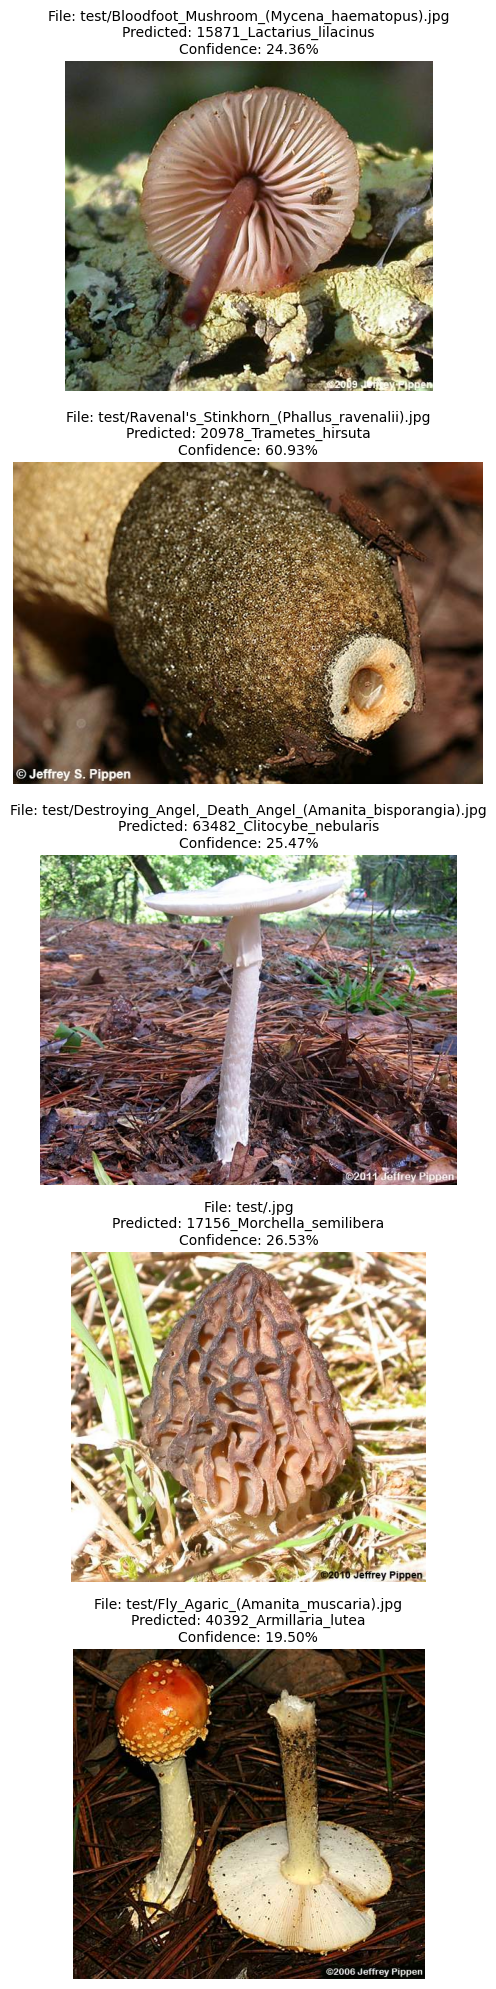

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

num_images = 5
fig, axs = plt.subplots(num_images, 1, figsize=(5, num_images * 4))

for i, image_file in enumerate(image_files):
    image_path = os.path.join(image_dir, image_file)
    pred_class, confidence = infer_image(image_path, model, transform, device)
    class_name = class_names[pred_class]

    parent_dir = os.path.basename(os.path.dirname(image_path))
    display_path = os.path.join(parent_dir, os.path.basename(image_path))
    
    confidence_prec = confidence * 100

    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title(f'File: {display_path}\nPredicted: {class_name}\nConfidence: {confidence_prec:.2f}%', fontsize=10)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# Model Convert

In [60]:
# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(
    model, 
    {torch.nn.Linear},  # Specify the layers to quantize, in this case, nn.Linear
    dtype=torch.qint8
)

# Save the quantized model
torch.save(quantized_model.state_dict(), model_name + '-quantized_model.pt')

In [63]:
# input_size = torch.rand(1, 3, 224, 224)
# scripted_model = torch.jit.trace(quantized_model, input_size)

scripted_model = torch.jit.script(quantized_model)

scripted_model.save(model_name + "-model_scripted.pt")

RuntimeError: false INTERNAL ASSERT FAILED at "../aten/src/ATen/quantized/Quantizer.cpp":444, please report a bug to PyTorch. cannot call qscheme on UnknownQuantizer